-----

# **Detecting Exceptional Case Resolutions (or Lack Thereof)**

-----
"Unusual" cases would be those that the model predicted would be solved with a high amount of confidence, but were unsolved. An "exceptional" case resolution would be those that the model predicted would go cold with a very high degree of confidence, yet did not. 

Factors that may contribute to the outliers:
* Accuracy of the data (not all sources may have the resources to report data with a high degree of accuracy/detail)
* Modern developments in forensic science and investigative procedures
* Heteroscedasticity from different funding levels of local agencies, geographic impact, differences in training, time of year, decade, etc.
* Size of city/locale and ease of identifying suspects

After the data is pre-processed and scaled, remaining relevant categorical features will be one hot encoded. The best binary classifier + hyperparams will be selected via cross-validation.

In [60]:
import calendar
import random
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.exceptions
from scipy.stats import randint as sp_randint
from sklearn import model_selection as ms
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

pd.options.mode.chained_assignment = None
%matplotlib inline
pd.set_option("display.max_columns", 45)

## **Data Import and Cleaning**

In [2]:
var_names = [
    "State",
    "Agentype",
    "Solved",
    "Year",
    "Month",
    "Homicide",
    "VicAge",
    "VicSex",
    "VicRace",
    "VicEthnic",
    "Weapon",
    "Relationship",
    "Circumstance",
    "Subcircum",
]

crime_data = pd.read_csv("crime_2019.csv", usecols=var_names, low_memory=False)


# Some of the age data may not exist, and thus must be set to NaN
# The number 999 denotes unknown information

crime_data["VicAge"] = pd.to_numeric(crime_data["VicAge"], "coerce")
crime_data["VicAge"].replace(999, crime_data["VicAge"].median(), inplace=True)

for col in set(crime_data.columns):
    try:
        crime_data[col] = pd.to_numeric(crime_data[col])
    except ValueError:
        crime_data[col] = crime_data[col].astype(str)


# Months are converted to integer values
d = dict((v, k) for k, v in enumerate(calendar.month_name))


# creating a copy to perform other EDA on
crime_data_all = crime_data

crime_data = crime_data[
    (crime_data.Relationship == "Relationship not determined")
    | (crime_data.Relationship == "Stranger")
]
crime_data["Month"] = crime_data["Month"].map(d)
crime_data["Solved"] = crime_data["Solved"].map({"Yes": 1, "No": 0})
crime_data["VicAgeBin"] = pd.cut(crime_data.VicAge, 4, precision=0)
crime_data.drop("Relationship", axis=1, inplace=True)

### **Comparing proportion of cases solved grouped by victim age to cases grouped by victim race**

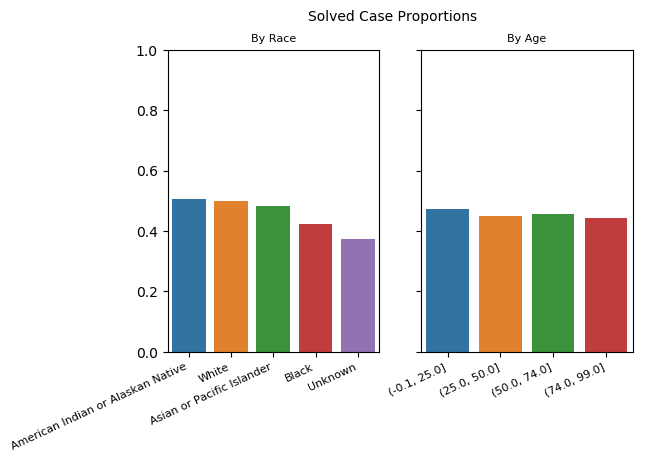

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

vic_race_pct = crime_data.groupby("VicRace").agg({"Solved": ["mean","count"]}).reset_index().sort_values(by=("Solved","mean"),ascending=False)#.rename(columns={"Solved": "Percent Solved"})
vic_age_pct = crime_data.groupby("VicAge").agg({"Solved": ["mean","count"]}).reset_index().sort_values(by=("Solved","mean"),ascending=False)#.rename(columns={"Solved": "Percent Solved"})




fig, (ax1, ax2) = plt.subplots(ncols=2,dpi=100,sharey=True)

sns.barplot(x= vic_race_pct["VicRace"],y=vic_race_pct[("Solved","mean")],ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=25, ha="right",fontsize=8);
ax1.set_title("By Race",fontsize=8)
ax1.set_xlabel("");
ax1.set_ylabel("");
ax1.set_ylim(0,1);

fig.suptitle('Solved Case Proportions', fontsize=10)





vic_race_pct = crime_data.groupby("VicAgeBin").agg({"Solved": ["mean","count"]}).reset_index().sort_values(by=("Solved","mean"),ascending=False)#.rename(columns={"Solved": "Percent Solved"})



ax2.set_xticklabels(ax2.get_xticklabels(), rotation=25, ha="right",fontsize=8);

sns.barplot(x= vic_race_pct["VicAgeBin"],y=vic_race_pct[("Solved","mean")],ax=ax2)
ax2.set_title("By Age",fontsize=8);
ax2.set_xlabel("");
ax2.set_ylabel("");
ax2.set_ylim(0,1);

###  **Exploring year and age distribution for unsolved+stranger crimes**

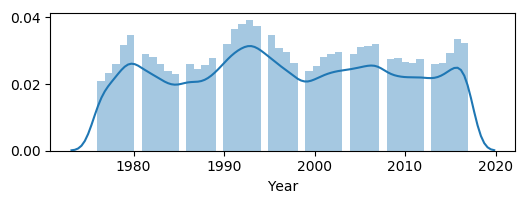

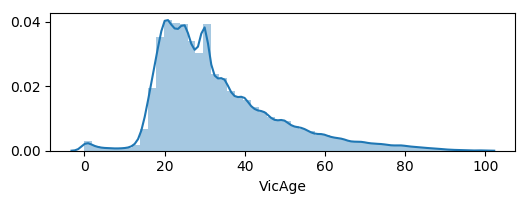

In [4]:
for i, col in enumerate(["Year", "VicAge"]):
    plt.figure(dpi=100)
    plt.subplot(2, 1, 1 + i)
    sns.distplot(crime_data[col].dropna())

### **Overall crimes distribution**

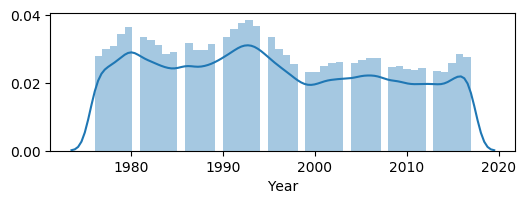

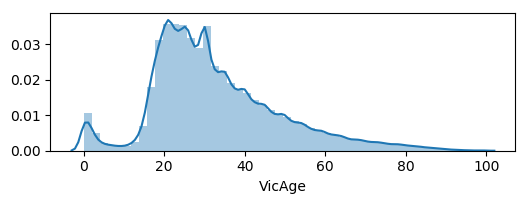

In [5]:
for i, col in enumerate(["Year", "VicAge"]):
        plt.figure(dpi=100)
        plt.subplot(2, 1, 1 + i)
        sns.distplot(crime_data_all[col].dropna())

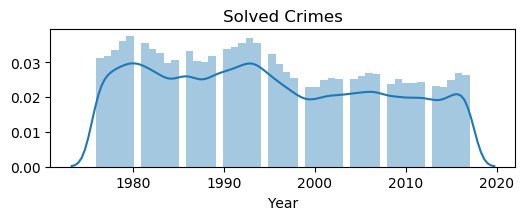

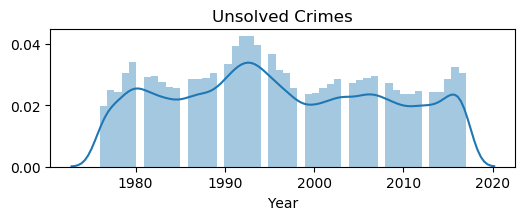

In [32]:
crim_un_solv = crime_data_all[crime_data_all.Solved == "No"]
crim_solv = crime_data_all[crime_data_all.Solved == "Yes"]
for i, col in enumerate(["Year", "Year"]):
        plt.figure(dpi=100)
        plt.subplot(2, 1, 1 + i)
        if i == 0:
            ax = sns.distplot(crim_solv[col].dropna())
            ax.set_title("Solved Crimes")
        else:
            ax = sns.distplot(crim_un_solv[col].dropna())
            ax.set_title("Unsolved Crimes")


## **Data Pre-Processing**

#### Predictive model will exclude data collected after 2009, cases older than 10 years are assumed in this analysis to have stable "solved/unsolved' status. Model will exclude data older than 1989, when DNA testing was not as available.

In [202]:
crime_data_ = crime_data[(crime_data["Year"] < 2009)
    & (crime_data["Year"] > 1989)]

#### Applying scaling to ensure numerical values are in the range [0,1]. Min-Max is used here for simplicity and the median is used for interpolation of missing values.

In [7]:
cols_scale = ["VicAge", "Year", "Month"]
scaler = MinMaxScaler()
crime_data_[cols_scale] = scaler.fit_transform(crime_data_[cols_scale])

#### One-hot encoding categorical variables that are relevant and also don't encapsulate the target.
#### The circumstance/subcircumstance variables include information about case status. 

In [8]:
OHE_cols = set(list(crime_data_.columns)) - set(
    cols_scale + ["Solved", "VicAgeBin", "Circumstance", "Subcircum"]
)
data = pd.get_dummies(crime_data_, columns=list(OHE_cols))

In [9]:
X = data.drop(["Solved", "VicAgeBin", "Circumstance", "Subcircum"], axis=1)
y = data["Solved"]

## ** Model Selection Experiments **

#### GridSearchCV was used to find the best hyperparameters. The metric of choice in scoring was the f1-score, a weighted average of precision and recall.

In [10]:
def cv_wrapper(clfObj, trgX, trgY, tstX, tstY, params, clf_type=None, dataset=None, full_search=False):
    if clf_type is None or dataset is None:
        raise NotImplementedError
    print("Doing CV for {}".format(clf_type))
    
    if full_search:
        cv = GridSearchCV(
            clfObj,
            param_grid=params,
            return_train_score=True,
            scoring="f1",
            verbose=1,
            cv=10,
        )
    else:
        cv = RandomizedSearchCV(clfObj, param_distributions=params, return_train_score=True,scoring="f1_weighted",verbose=100,cv=4,n_iter=10)
    cv.fit(trgX, trgY)

    return cv

### ** Collection of classifiers and hyperparameters to search over:**

In [14]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

xgbc = XGBClassifier()
dt = DecisionTreeClassifier()


classifiers = {"gbc": xgbc, "dt": dt}
dt_params = {
    "max_depth": [3, None, 5, 7, 8],
    "splitter": ["best", "random"],
    "max_features": ["auto", "log2"],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [2, 5, 10, 20],
    "min_impurity_decrease": np.random.uniform(0, 0.1, 10),
    "criterion": ["gini", "entropy"],
}
gradient_boost_params = {
    "learning_rate": [0.1, 0.05],
    "max_depth": [3,8],
    "gamma": [0, 0.1, 1, 5, 10],
    "max_delta_step": [0, 1],
}

#svm_params = {"kernel": ["linear"], "C": [0.1, 1, 5, 10, 100]}
#knn_params = {"n_neighbors": [3, 5, 7, 9, 11], "weights": ["uniform", "distance"]}

params_store = {
    "gbc": gradient_boost_params,
    "dt": dt_params
}

In [ ]:
cvresults = [
    basicResults(
        value,
        trainX,
        trainY,
        testX,
        testY,
        params_store[key],
        clf_type=key,
        dataset="Case Difficulty",
    )
    for key, value in classifiers.items()
]

## ** Best Model Results ** 
####  The best model was found to be a gradient boosting classifier with a learning rate of 0.1, gamma of 1, and max_depth of 8 

In [ ]:
clf = XGBClassifier(learning_rate=.1,gamma=1,max_depth=8,silent=False)

trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.5)
y_score = clf.fit(trainX, trainY)


In [170]:
y_true = testY
y_pred = clf.predict(testX)
target_names = ["Unsolved", "Solved"]
print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=target_names))

0.6458449412932703
             precision    recall  f1-score   support

   Unsolved       0.65      0.76      0.70     54015
     Solved       0.64      0.51      0.56     44696

avg / total       0.64      0.65      0.64     98711



## **Important Features**

In [171]:
feature_importances = pd.DataFrame(
    clf.feature_importances_, index=trainX.columns, columns=["importance"]
).sort_values("importance", ascending=False)
feature_importances.head()

,importance
VicAge,0.250524
Year,0.207531
Month,0.147569
"Weapon_Handgun - pistol, revolver, etc",0.024500
VicSex_Female,0.024309


#### The top features of importance include the age of the victim and the year of the case. It is possible that there are fewer unsolved cases as time goes on and the data gets updated, causing the year to be important.

#### An unusual feature of importance is the month that a case is reported. This may be due to the workload and yearly backlog of various departments having an impact on time-sensitive case resolutions.

## **Anomalous and Misclassified Cases**

In [267]:
testY_ = np.asarray(testY)
misclassified = np.where(testY_ != clf.predict(testX))
cases = testX.iloc[misclassified]


missed_cases = crime_data_.iloc[misclassified]

#Probabilities are calculated for the misclassified cases
probs = pd.DataFrame(clf.predict_proba(cases))
probs.rename(columns={0:"UnsolvedProb",1:"SolvedProb"},inplace=True)
probs.index = missed_cases.index

#Missed cases original data is recovered
missed_cases = pd.concat([missed_cases,probs],axis=1)
missed_cases["Diff"] =missed_cases["SolvedProb"] - missed_cases["UnsolvedProb"]
#missed_cases["Diff"] = missed_cases["Diff"].abs()

### Hard to classify cases:

In [327]:
mf= lambda x: x.value_counts().index[0]
missed_cases.groupby(["VicRace"]).agg({"Solved":"mean","Circumstance":mf,"State":mf}).sort_values(by="Solved")

,Solved,Circumstance,State
VicRace,,,
Unknown,0.283105,Circumstances undetermined,California
Black,0.389294,Circumstances undetermined,New York
Asian or Pacific Islander,0.449686,Robbery,California
White,0.473566,Circumstances undetermined,California
American Indian or Alaskan Native,0.505747,Circumstances undetermined,California


### Most frequent overall from original data:

In [328]:
crime_data.groupby(["VicRace"]).agg({"Solved":"mean","Circumstance":mf,"State":mf}).sort_values(by="Solved")

,Solved,Circumstance,State
VicRace,,,
Unknown,0.373194,Circumstances undetermined,California
Black,0.424313,Circumstances undetermined,New York
Asian or Pacific Islander,0.482382,Circumstances undetermined,California
White,0.498200,Circumstances undetermined,California
American Indian or Alaskan Native,0.506783,Circumstances undetermined,Arizona
